In [1]:
import numpy as np
import pandas as pd
import pickle
import numpy as np
import random
import time
import os
#os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from keras import optimizers
#from sklearn.metrics import classification_report, confusion_matrix
import sklearn
import seaborn as sn
from keras.callbacks import CSVLogger, LambdaCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import shutil

# Path to the image file in Google Drive
source_path = '/content/drive/MyDrive/Project_482/best_weights.15_Class_Normal.rgb.256p.TL.3D.InceptionV3.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5'  # Update with the actual path

# Destination path in Colab
destination_path = '/content/best_weights.15_Class_Normal.rgb.256p.TL.3D.InceptionV3.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5'  # Update with the desired destination path

# Copy the image file
shutil.copyfile(source_path, destination_path)


'/content/best_weights.15_Class_Normal.rgb.256p.TL.3D.InceptionV3.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5'

In [7]:
# Path to the dataset file in Google Drive
dataset_path_drive = '/content/drive/MyDrive/Project_482/Augmented_Dataset.zip'

# Path to the destination directory in Colab
dataset_path_colab = '/content/aug_dataset.zip'

# Copy the dataset file from Google Drive to Colab
!cp "{dataset_path_drive}" "{dataset_path_colab}"


In [8]:
!unzip /content/aug_dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: Augmented_Dataset/train/PD/2229a.jpg  
  inflating: Augmented_Dataset/train/PD/2268a.jpg  
  inflating: Augmented_Dataset/train/PD/PD_814.png  
  inflating: Augmented_Dataset/train/PD/PD_16.png  
  inflating: Augmented_Dataset/train/PD/2335a.jpg  
  inflating: Augmented_Dataset/train/PD/PD_445.png  
  inflating: Augmented_Dataset/train/PD/PD_873.png  
  inflating: Augmented_Dataset/train/PD/PD_708.png  
  inflating: Augmented_Dataset/train/PD/PD_270.png  
  inflating: Augmented_Dataset/train/PD/PD_834.png  
  inflating: Augmented_Dataset/train/PD/2397a.jpg  
  inflating: Augmented_Dataset/train/PD/1756a.jpg  
  inflating: Augmented_Dataset/train/PD/3129a.jpg  
  inflating: Augmented_Dataset/train/PD/2965a.jpg  
  inflating: Augmented_Dataset/train/PD/2842a.jpg  
  inflating: Augmented_Dataset/train/PD/1433a.jpg  
  inflating: Augmented_Dataset/train/PD/PD_468.png  
  inflating: Augmented_Dataset/train/PD/1430a.jpg  
  infl

In [9]:
#frameRate = 1
base_dir = f'/content/Augmented_Dataset'


#train_dir = os.path.join(base_dir) #, 'train_patch'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

work_dir = "./"
color_type = 'rgb' # rgb, grayscale
BATCH_SIZE = 64
#validation_split = 0.5
img_dim = (256,256)
#list_classes = ['Monocot_Eichhornia','Monocot_Musa'] #'Monocot_Cocos',

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   #rotation_range=90,
                                   #validation_split=validation_split
                                   )
val_datagen = ImageDataGenerator(rescale=1./255,
                                #validation_split=validation_split
                                )
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_dim,
        batch_size=BATCH_SIZE,
        color_mode=color_type, # grayscale, rgb
        class_mode='categorical',
        interpolation='lanczos',
        #classes=list_classes,
        #subset='training'
        )

Found 8815 images belonging to 3 classes.


In [12]:
num_classes = train_generator.num_classes
total_train_data = train_generator.samples

print(f"total_train_data = {total_train_data}")
print(f"train_generator.image_shape = {train_generator.image_shape}")
print(f"num_classes = {num_classes}")

total_train_data = 8815
train_generator.image_shape = (256, 256, 3)
num_classes = 3


In [13]:
val_generator = val_datagen.flow_from_directory(
        val_dir,
        shuffle=False,
        target_size=img_dim,
        batch_size=BATCH_SIZE,
        color_mode=color_type, # grayscale, rgb
        class_mode='categorical',
        interpolation='lanczos',
        #classes=list_classes,
        #subset='validation'
        )

Found 1651 images belonging to 3 classes.


In [14]:
total_val_data = val_generator.samples
print(f"total_val_data = {total_val_data}")

total_val_data = 1651


In [15]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        shuffle=False,
        target_size=img_dim,
        batch_size=BATCH_SIZE,
        color_mode=color_type, # grayscale, rgb
        class_mode='categorical',
        interpolation='lanczos',
        #classes=list_classes,
        #subset='validation'
        )

Found 551 images belonging to 3 classes.


In [16]:
total_test_data = test_generator.samples
print(f"total_test_data = {total_test_data}")

total_test_data = 551


In [17]:
# DenseNet121 ResNet101 ResNet50 DenseNet201 InceptionV3 Xception NASNetLarge ResNet152V2 InceptionResNetV2 EfficientNetB7
model_name = "InceptionV3"
impl_type = f"TL.3D.{model_name}" # TransferLearning3D
dataset = f"15_Class_Normal.{color_type}.{train_generator.image_shape[1]}p" # +str(img_size)+"p"
dataset

'15_Class_Normal.rgb.256p'

In [18]:
#'''
count_no_improvement = 0
epoch_initial = True
#'''

In [19]:
#NUM_NEURONS = 16
#NUM_LAYERS = 3
#BATCH_SIZE = 16 # 10
NUM_EPOCHS = 100
epochs_completed = 0
LEARNING_RATE = 0.0001
EPSILON = 1e-5
early_stop_after_epochs = 5
DROPOUT = 0.5 # 0.5 0.0
pad = 0

LOSS = 'categorical_crossentropy'
ACTIVATION_FUNCTION = 'relu' # relu sigmoid elu
FINAL_ACTIVATION_FUNCTION = 'softmax'
validation_split = 0.1
kernel_size=(1,1)
pointTrainableAfter = "allDefault" # "allDefault", "allFalse", 160, 170
OPTIMIZER = "Adam" # Adam SGD RMSProp
init_weights = "imagenet" # "imagenet" None
modelExt = "" #.Dense.1024.1024.2048 .Dense.128.256.512, .512.512.512 .Dense.512.512.512.512.Res
l2_val = 0.001

# +"_kernel"+str(kernel_size)+"_lr"+str(LEARNING_RATE)+"_batch"+str(BATCH_SIZE)+"_epochs"+str(NUM_EPOCHS)
#checkpointer_name  = "weights_"+dataset+"_"+impl_type+"_nLayers"+str(NUM_LAYERS)+"_nNeurons"+str(NUM_NEURONS)+".hdf5"
ext = f"" #.Flatten.l2.{str(l2_val)}.run_1 run_1 run_2 .DropAfter .momentum0.9
#'''
checkpointer_name  = "weights."+dataset+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+\
                     ".lr"+str(LEARNING_RATE)+".opt."+OPTIMIZER+".batch"+str(BATCH_SIZE)+ext+".hdf5"
log_name = "log."+checkpointer_name[8:-5]+".log"

print('checkpointer_name =', checkpointer_name)
print('log_name =', log_name)
#'''

checkpointer_name = weights.15_Class_Normal.rgb.256p.TL.3D.InceptionV3.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5
log_name = log.15_Class_Normal.rgb.256p.TL.3D.InceptionV3.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.log


In [20]:
train_generator.image_shape

(256, 256, 3)

In [21]:
#'''
#base_model=DenseNet121(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:]) # `None` (random initialization)
#base_model=ResNet152V2(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:])
# ResNet152V2 ResNet50 ResNet101 ResNet152 DenseNet201 InceptionV3 Xception NASNetLarge 'imagenet' DenseNet121
#inputs = Input(final_train_imageset.shape[1:])
#x = ZeroPadding2D(padding=(pad,pad))(inputs)
#base_model=tf.keras.applications.ResNet50(weights=init_weights, include_top=False, input_tensor=x)

inputs = train_generator.image_shape
if model_name == 'ResNet50':
    base_model=tf.keras.applications.ResNet50(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'ResNet101':
    base_model=tf.keras.applications.ResNet101(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'ResNet152':
    base_model=tf.keras.applications.ResNet152(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'ResNet50V2':
    base_model=tf.keras.applications.ResNet50V2(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'ResNet101V2':
    base_model=tf.keras.applications.ResNet101V2(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'ResNet152V2':
    base_model=tf.keras.applications.ResNet152V2(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'InceptionV3':
    base_model=tf.keras.applications.InceptionV3(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'MobileNet':
    base_model=tf.keras.applications.MobileNet(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'MobileNetV2':
    base_model=tf.keras.applications.MobileNetV2(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'Xception':
    base_model=tf.keras.applications.Xception(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'NASNetMobile':
    base_model=tf.keras.applications.NASNetMobile(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'NASNetLarge':
    base_model=tf.keras.applications.NASNetLarge(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'InceptionResNetV2':
    base_model=tf.keras.applications.InceptionResNetV2(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'VGG16':
    base_model=tf.keras.applications.VGG16(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'VGG19':
    base_model=tf.keras.applications.VGG19(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'DenseNet121':
    base_model=tf.keras.applications.DenseNet121(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'DenseNet169':
    base_model=tf.keras.applications.DenseNet169(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'DenseNet201':
    base_model=tf.keras.applications.DenseNet201(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'EfficientNetB0':
    base_model=tf.keras.applications.EfficientNetB0(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'EfficientNetB1':
    base_model=tf.keras.applications.EfficientNetB1(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'EfficientNetB2':
    base_model=tf.keras.applications.EfficientNetB2(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'EfficientNetB3':
    base_model=tf.keras.applications.EfficientNetB3(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'EfficientNetB4':
    base_model=tf.keras.applications.EfficientNetB4(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'EfficientNetB5':
    base_model=tf.keras.applications.EfficientNetB5(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'EfficientNetB6':
    base_model=tf.keras.applications.EfficientNetB6(weights=init_weights, include_top=False, input_shape=inputs)
elif model_name == 'EfficientNetB7':
    base_model=tf.keras.applications.EfficientNetB7(weights=init_weights, include_top=False, input_shape=inputs)
    print(f"model_name = {model_name}")

x=base_model.output
#x = Activation(ACTIVATION_FUNCTION)(x)
x = Flatten()(x)
'''
x = Dense(1024,activation='elu')(x)
x = Dense(512,activation='elu')(x)
x = Dense(512,activation='elu')(x)
#'''
outputs=Dense(num_classes,activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=outputs)
#model.summary()

print(f"model_name = {model_name}")
#'''

87910968/87910968 [==============================] - 0s 0us/step
model_name = InceptionV3


In [22]:
'''
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64
)
#'''

"\ntf.keras.utils.plot_model(\n    model, to_file='model.png', show_shapes=True, show_dtype=False,\n    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64\n)\n#"

In [22]:
#layer_names=[layer.name for layer in base_model.layers]
num_layers_base_model = len(base_model.layers)
num_layers_model = len(model.layers)

print(f"num_layers_base_model = {num_layers_base_model}")
print(f"num_layers_model = {num_layers_model}")

count_trainable = 0
count_non_trainable = 0

#'''
if pointTrainableAfter == "allDefault":
    for layer in base_model.layers:
        layer.trainable=True
        count_trainable += 1
elif pointTrainableAfter == "allFalse":
    for layer in base_model.layers:
        layer.trainable=False
        count_non_trainable += 1
elif pointTrainableAfter > 0:
    for layer in base_model.layers[:pointTrainableAfter]: # [:-pointTrainableAfter]
        layer.trainable=False
        count_non_trainable += 1
    for layer in base_model.layers[pointTrainableAfter:]: # [-pointTrainableAfter:]
        layer.trainable=True
        count_trainable += 1
#'''

'''
for layer in model.layers:
    layer.trainable=True
    count_trainable += 1
#'''

print("count_non_trainable =", count_non_trainable)
print("count_trainable =", num_layers_model-count_non_trainable)
print("Total number of layers =", num_layers_model)

num_layers_base_model = 311
num_layers_model = 313
count_non_trainable = 0
count_trainable = 313
Total number of layers = 313


In [23]:
# "RMSProp" "SGD" "Adam" "Adamax" "Adadelta" "Adagrad" "SGD"
#optimizer = tf.keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)

if OPTIMIZER == "RMSProp":
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = LEARNING_RATE, epsilon=EPSILON)
elif OPTIMIZER == "Adam":
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adamax":
    optimizer = tf.keras.optimizers.Adamax(learning_rate = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adadelta":
    optimizer = tf.keras.optimizers.Adadelta(learning_rate = LEARNING_RATE, epsilon=EPSILON, rho=0.95)
elif OPTIMIZER == "Adagrad":
    optimizer = tf.keras.optimizers.Adagrad(learning_rate = LEARNING_RATE, epsilon=EPSILON, initial_accumulator_value=0.1)
elif OPTIMIZER == "SGD":
    optimizer = tf.keras.optimizers.SGD(learning_rate = LEARNING_RATE, momentum=0.9)

model.compile(
    #optimizer=OPTIMIZER,
    optimizer=optimizer,
    loss=LOSS,
    metrics=['accuracy']
)

print("OPTIMIZER =", OPTIMIZER)

OPTIMIZER = Adam


In [24]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = work_dir+checkpointer_name,
                               #monitor='val_accuracy',
                               monitor='val_loss',
                               save_weights_only=False,
                               mode='auto',
                               verbose = 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                               save_best_only =False
                               )
checkpointer_best = ModelCheckpoint(filepath = work_dir+"best_"+checkpointer_name,
                                    monitor='val_loss',
                                    save_weights_only=False,
                                    mode='auto',
                                    verbose = 1,
                                    save_best_only = True
                                    )
early_stopping = EarlyStopping(monitor='val_accuracy', patience=early_stop_after_epochs)

In [25]:
'''
if 'count_no_improvement' not in globals():
    count_no_improvement = 0
    print("count_no_improvement =", count_no_improvement)
#'''
'''
count_no_improvement = 0 # 0
epoch_initial = False
#'''
min_delta = 0.0009
print("count_no_improvement =", count_no_improvement)

def checkBestPerformance(epoch, logs):
    save_filepath = work_dir+"best_"+checkpointer_name

    global epoch_initial
    #print(f"epoch_initial = {epoch_initial}")
    if epoch_initial == True:
        epoch_initial = False
        model.save(filepath = save_filepath)
        print(". Model saved!")

    elif epoch_initial == False:
        global count_no_improvement

        log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['val_loss', 'val_accuracy'], engine='python')
        min_val_loss = float(str(min(log_data.val_loss.values))[:6])
        max_val_acc = float(str(max(log_data.val_accuracy.values))[:6])

        current_val_acc = float(str(logs['val_accuracy'])[:6])
        current_val_loss = float(str(logs['val_loss'])[:6])

        if (current_val_loss < min_val_loss) and (abs(current_val_loss-min_val_loss) >= min_delta):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_loss decreased from",min_val_loss," to",current_val_loss,"( val_accuracy =",current_val_acc,").")

        elif (current_val_loss==min_val_loss) and (current_val_acc>max_val_acc):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_accuracy increased to", current_val_acc, ".")

        else:
            count_no_improvement += 1
            print(". count_no_improvement =", count_no_improvement)

        if count_no_improvement >= early_stop_after_epochs-1:
            global list_callbacks
            del list_callbacks, count_no_improvement
            #print("count_no_improvement =", count_no_improvement, "... list_callbacks =", list_callbacks)

count_no_improvement = 0


In [26]:
epochs_completed = 0
list_callbacks = []
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)

#if 'list_callbacks' in globals():
#    del list_callbacks

try:
    log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
    epochs_completed = log_data.shape[0]

    #if epochs_completed > 0:
    model = load_model(work_dir+checkpointer_name)
    list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
    print("epochs_completed =", epochs_completed)

except Exception as error:
    if epochs_completed == 0:
        # list_callbacks = [checkpointer, checkpointer_best, csv_logger, early_stopping]
        list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
        print("epochs_completed =", epochs_completed)
    elif epochs_completed > 0:
        print(error)

print('checkpointer_name =', checkpointer_name)

epochs_completed = 0
checkpointer_name = weights.15_Class_Normal.rgb.256p.TL.3D.InceptionV3.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5


In [ ]:
print('checkpointer_name =', checkpointer_name)
print("Previously completed epochs =", epochs_completed)
print("count_no_improvement =", count_no_improvement, "\n")

#'''
try:
    start_time = time.time()
    history = model.fit(train_generator,
                        steps_per_epoch=total_train_data // BATCH_SIZE,
                        shuffle=True,
                        epochs = NUM_EPOCHS - epochs_completed,
                        validation_data=val_generator,
                        validation_steps=total_val_data // BATCH_SIZE,
                        callbacks=list_callbacks
                        )
    elapsed_time = time.time() - start_time
    print("\nTime elapsed: ", elapsed_time)
except Exception as error:
    print("\nError:", error)
#'''

In [4]:
#checkpointer_name = "weights.Fashion.DenseNet121.wInit.None.TrainableAfterallDefault.opt.SGD.drop.0.0.batch32.Flatten.run_1.hdf5"
model_loaded = load_model("/content/best_weights.15_Class_Normal.rgb.256p.TL.3D.InceptionV3.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5")
print("/content/best_weights.15_Class_Normal.rgb.256p.TL.3D.InceptionV3.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5")

/content/best_weights.15_Class_Normal.rgb.256p.TL.3D.InceptionV3.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5


In [27]:
'''
Record: :
;
---


'''
'''
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)
log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
epochs_completed = log_data.shape[0]
#'''

result2 = model_loaded.evaluate(test_generator, steps=total_test_data // BATCH_SIZE)
#print("nLayers: {}, nNeurons: {}, DROPOUT: {}, Test Acc: {}, Test Loss: {}".format(NUM_LAYERS, NUM_NEURONS, DROPOUT, round(result2[1], 4), round(result2[0], 4)))
print("Test Acc: {}, Test Loss: {}: ep{}, {}\n".format(round(result2[1],4), round(result2[0],4), epochs_completed, "best_"+checkpointer_name))


8/8 [==============================] - 11s 372ms/step - loss: 0.8314 - accuracy: 0.8008
Test Acc: 0.8008, Test Loss: 0.8314: ep0, best_weights.15_Class_Normal.rgb.256p.TL.3D.InceptionV3.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.hdf5



In [28]:
import csv

with open(work_dir+'Records.csv', "a") as fp:
    wr = csv.writer(fp, dialect='excel')
    try:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4), elapsed_time])
    except:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4)])
print("Saved results.")

Saved results.


In [29]:
#Confution Matrix and Classification Report
#'''
Y_pred = model_loaded.predict_generator(test_generator, verbose=1)
#'''
#'''
save_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"
np.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)
print(f"Saved: {work_dir}{save_predictions_filename}")
#'''

<ipython-input-29-5b75b41eb0a6>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model_loaded.predict_generator(test_generator, verbose=1)


9/9 [==============================] - 9s 965ms/step
Saved: ./Y_pred.15_Class_Normal.rgb.256p.TL.3D.InceptionV3.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64


In [30]:
Y_pred_loaded = np.load(f"{work_dir}{save_predictions_filename}.npy", allow_pickle=True)
print(f"Y_pred_loaded.shape = {Y_pred_loaded.shape}")

Y_pred_loaded.shape = (551, 3)


In [31]:
y_pred = np.argmax(Y_pred_loaded, axis=1)

In [32]:
y_true = test_generator.classes

In [34]:
list_class_names_in_generator = list(test_generator.class_indices.keys())
list_class_names_in_generator[:3]

['AD', 'CONTROL', 'PD']

In [35]:
conf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

Confusion Matrix:
[[157  27   0]
 [ 70 108   5]
 [  0   0 184]]


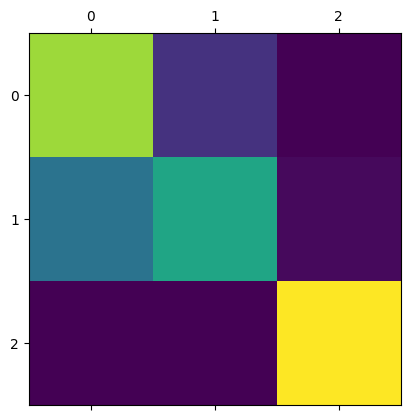

In [36]:
#plt.figure(figsize = (30,30))
plt.matshow(conf_matrix)

In [37]:
df_conf_matrix = pd.DataFrame(conf_matrix, index = [f"Class {i+1}" for i in range(num_classes)],
                  columns = [f"Class {i+1}" for i in range(num_classes)])

img_path = ./image_conf_matrix_15_Class_Normal.rgb.256p.TL.3D.InceptionV3.wInit.imagenet.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch64.png


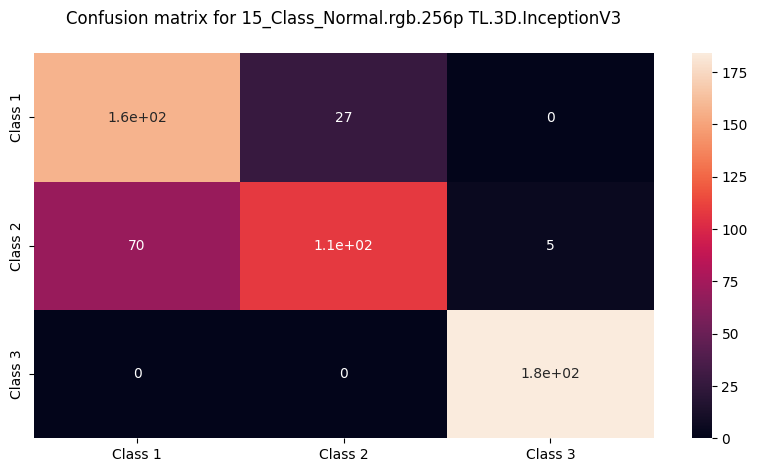

In [38]:
title = "Confusion matrix for "+dataset+" "+impl_type+"\n"
plt.figure(figsize = (10,5))
plt.title(title)
sn.heatmap(df_conf_matrix, annot=True)

img_path = work_dir+'image_conf_matrix_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
print(f"img_path = {img_path}")

In [39]:
val_generator.class_indices.keys()

dict_keys(['AD', 'CONTROL', 'PD'])

In [40]:
#'''
print('Classification Report')
print(sklearn.metrics.classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))
#'''

Classification Report
              precision    recall  f1-score   support

          AD       0.69      0.85      0.76       184
     CONTROL       0.80      0.59      0.68       183
          PD       0.97      1.00      0.99       184

    accuracy                           0.81       551
   macro avg       0.82      0.81      0.81       551
weighted avg       0.82      0.81      0.81       551



In [41]:
from IPython.display import FileLink
FileLink(r'./best_weights.LeafVein.Species.MonoAndDicot.rgb.384p.1fps.DF.TL.3D.DenseNet201.wInit.None.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch16.hdf5')


/content/best_weights.LeafVein.Species.MonoAndDicot.rgb.384p.1fps.DF.TL.3D.DenseNet201.wInit.None.TrainableAfter.allDefault.lr0.0001.opt.Adam.batch16.hdf5

In [43]:
from sklearn.metrics import accuracy_score,classification_report, roc_auc_score, matthews_corrcoef, hamming_loss, cohen_kappa_score, jaccard_score

y_actual = y_true
y_pred = y_pred

acc = classification_report(y_actual,y_pred,target_names=test_generator.class_indices.keys())
accuracy = accuracy_score(y_actual, y_pred)
mcc = matthews_corrcoef(y_actual, y_pred)
print(f"{acc}")
print(f"Accuracy Score : {accuracy}")
print(f"mcc_score : {mcc}")

hl = hamming_loss(y_actual, y_pred)
print(f"hamming_loss : {hl}")
cks = cohen_kappa_score(y_actual, y_pred)
print(f"cohen_kappa_score : {cks}")
jc = jaccard_score(y_actual, y_pred, average='weighted')
print(f"jaccard_score : {jc}")

              precision    recall  f1-score   support

          AD       0.69      0.85      0.76       184
     CONTROL       0.80      0.59      0.68       183
          PD       0.97      1.00      0.99       184

    accuracy                           0.81       551
   macro avg       0.82      0.81      0.81       551
weighted avg       0.82      0.81      0.81       551

Accuracy Score : 0.8148820326678766
mcc_score : 0.7298318797189316
hamming_loss : 0.1851179673321234
cohen_kappa_score : 0.7222562663082154
jaccard_score : 0.7023209515628454


In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

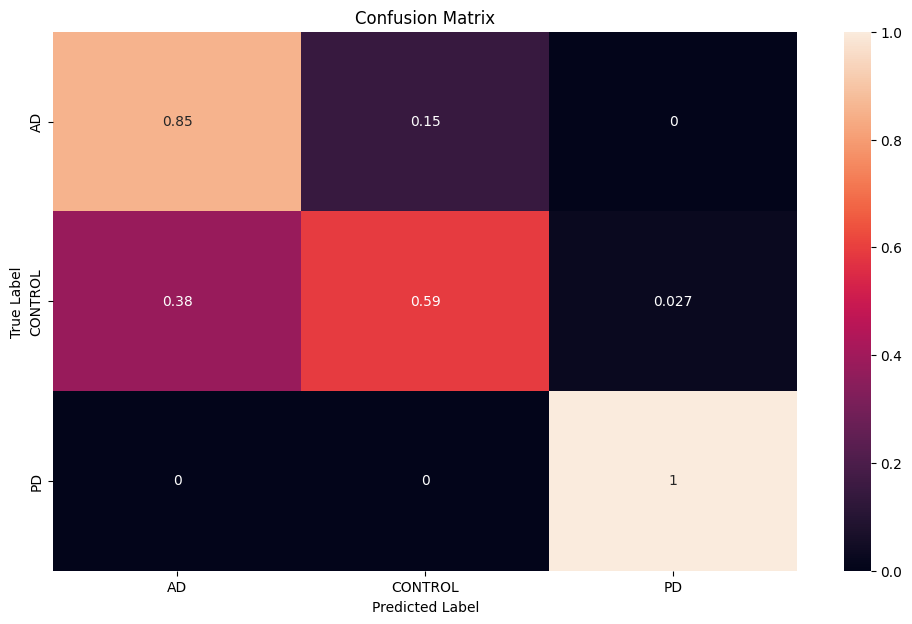

In [46]:
# constant for classes
classes = ('AD', 'CONTROL', 'PD')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
#plt.xticks(rotation=45)
plt.savefig('Confusion_matrix_output_float_latest.png',dpi=1000, bbox_inches='tight')

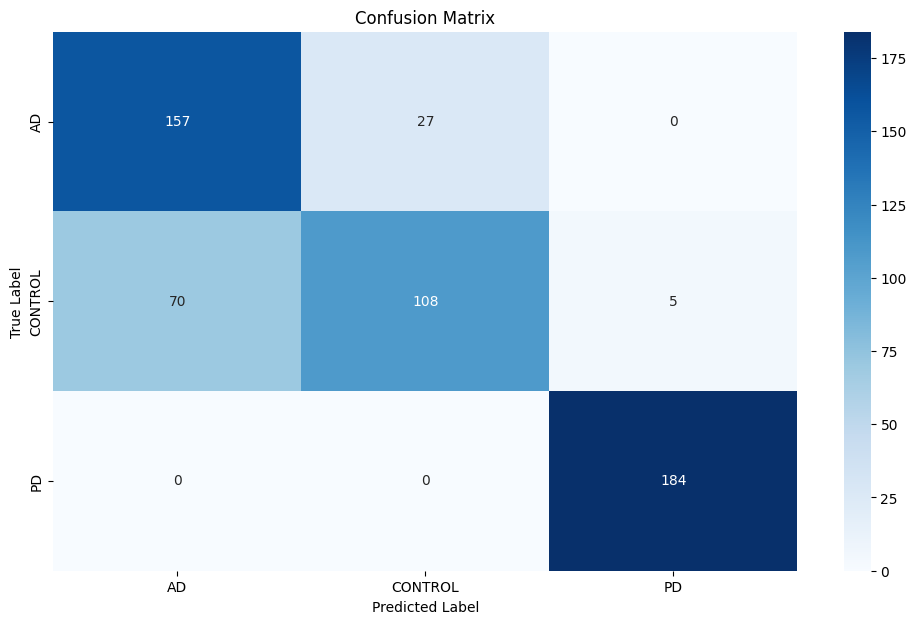

In [47]:
# Plot the confusion matrix using Seaborn heatmap
cf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, cmap="Blues", annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('Confusion_matrix_output_integer_latest.png',dpi=1000, bbox_inches='tight')
plt.show()

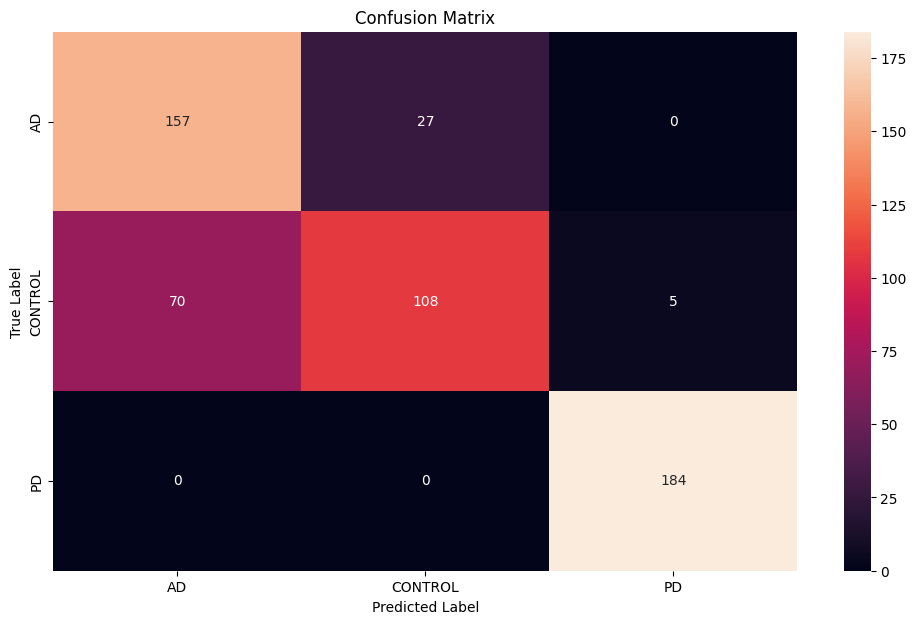

In [48]:
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('Confusion_matrix_output_integer_latest.png',dpi=1000, bbox_inches='tight')
plt.show()

In [50]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=60f4c4d02da1e15f34a6adc0b21cc639b40a59847063c9ca0c0d4ec0d7496de0
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [51]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

import lime
from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries

np.random.seed(123)

In [52]:
print(f" Version of tensorflow used: {tf.__version__}")

 Version of tensorflow used: 2.15.0


In [53]:
def load_image_data_from_url(url):
    '''
    Function to load image data from online
    '''
    # The local path to our target image
    image_path = keras.utils.get_file(
    "shark.jpg", url
    )

    display(Image(image_path))
    return image_path

In [54]:
image_path = '/content/Augmented_Dataset/test/AD/AD_3050.png'

In [55]:
IMG_SIZE = (256,256)
def transform_image(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0

    return img

normalized_img = transform_image(image_path, IMG_SIZE)

In [56]:
normalized_img.shape

(1, 256, 256, 3)

In [57]:
def get_model_predictions(data):

    model_prediction = model_loaded.predict(data)

    probability = max(model_prediction[0])
    print("predicted probability: ", probability)

    # Getting indices of N = 1 maximum values
    x = np.argsort(model_prediction[0])[::-1][:5]
    print("Indices:",x)

    # Getting N maximum values
    print("Values:",model_prediction[0][x])
    #rint("Values:",model_prediction[0][x[0]])

    return model_prediction[0][x[0]]

1/1 [==============================] - 3s 3s/step
predicted probability:  0.5681336
Indices: [1 0 2]
Values: [0.5681336 0.3708823 0.0609841]
0.5681336


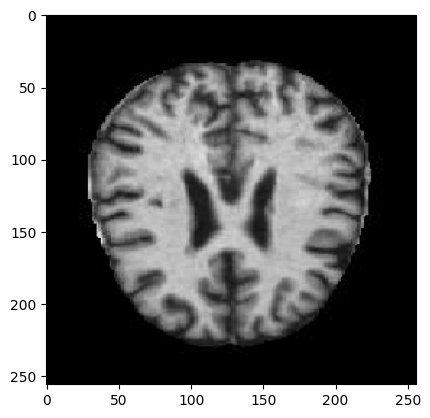

In [58]:
plt.imshow(normalized_img[0])
pred_orig = get_model_predictions(normalized_img)
print(pred_orig)

In [59]:
explainer = lime_image.LimeImageExplainer()

In [60]:
exp = explainer.explain_instance(normalized_img[0],
                                 model_loaded.predict,
                                 top_labels=5,
                                 hide_color=0,
                                 num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


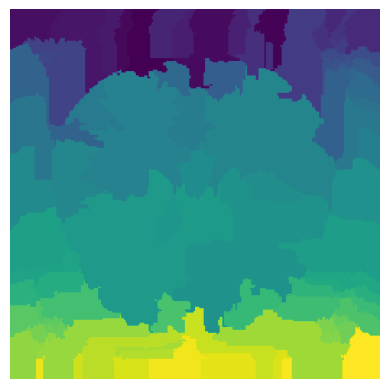

In [61]:
plt.imshow(exp.segments)
plt.axis('off')
plt.savefig('1. Heatmap image generated by LIME on our inference image.png',dpi=1000)
plt.show()

In [63]:
def generate_prediction_sample(exp, exp_class, weight = 0.001, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class,
                                         positive_only=show_positive,
                                         num_features=6,
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    #plt.savefig('2. Most important super-pixel picked up by LIME to predict the output.png',dpi=1000)
    #plt.savefig('3. Most important super-pixel picked up by LIME to predict the output with the background image.png',dpi=1000)
    plt.savefig('4. Most important super-pixel picked up by LIME to predict the output with the background image and green overlay to highlight the positive region.png',dpi=1000)
    plt.show()

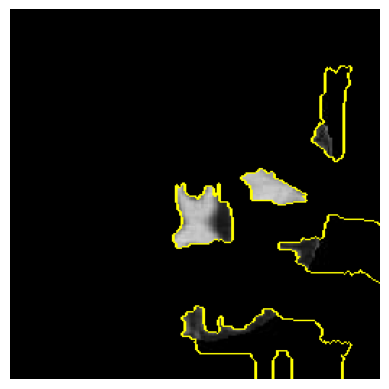

In [64]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

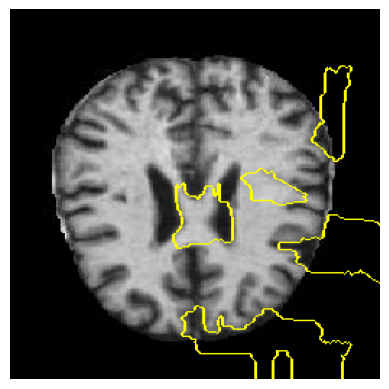

In [65]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)

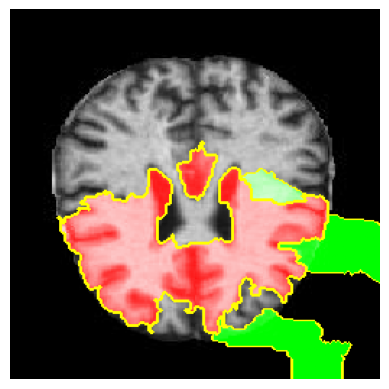

In [66]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = False, hide_background = False)

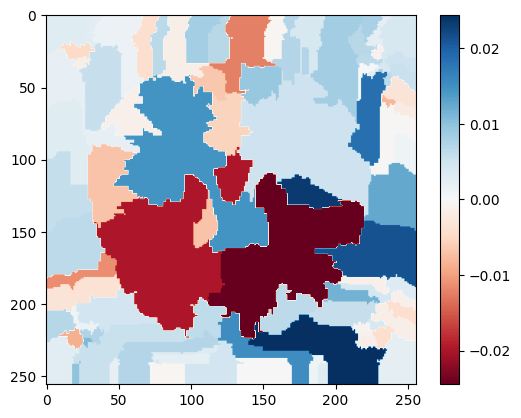

In [67]:
def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments)
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.savefig('5. Explanation Heatmap using LIME.png',dpi=1000)
    plt.show()

explanation_heatmap(exp, exp.top_labels[0])